In [2]:
import numpy as np
import scipy as sp
import astropy as ap

from numpy import linalg as la

import time as ttime

from scipy import signal

import sys

sys.path.append('/users/thomas/desktop/repos/maria/maria')

import matplotlib as mpl
import matplotlib.pyplot as plt

exec(open('/users/thomas/mpl_prefs').read())

In [3]:
# model.array.get_beam_filter(z, dx, dy, f)

In [4]:


gauss_8 = lambda r, r_fwhm : np.exp(np.log(0.5)*np.abs(r/r_fwhm)**8)

beam_func = gauss_8

r_ = np.linspace(0,10,1024)

#plt.plot(r_, beam_func(r_, 5))

In [5]:
time = np.arange(0,600,0.1)

period = 60


az = 15
el = 45

az_throw = 10
el_throw = 5


phase = 2*np.pi*time/period % (2*np.pi)



In [6]:
from datetime import datetime

import maria 
from maria import tools

import importlib
importlib.reload(maria)

<module 'maria' from '/Users/thomas/Desktop/repos/maria/maria/__init__.py'>

In [7]:
array = maria.array()
plan  = maria.plan()
site  = maria.site()

array.put({ 'n_det' : 256,  
            'shape' : 'hex',
            'primary_size' : 5,
            'bands' : np.repeat(1e9*np.linspace(150,160,4),16)})

plan.put({'scan_type' : 'baf', 'duration' : 600, 'az_throw' : 5, 'el_throw' : 0})

model = maria.lam(array, plan, site)
%time model.initialize(verbose=True)

Computing weights: 100%|██████████| 2/2 [00:00<00:00, 17.44it/s]


 # | depth (m) | beam (m) | beam (') | sim (m) | sim (') | rms (mg/m2) | n_cov | orth | para | h2o (mg/m3) | temp (K) | ws (m/s) | wb (deg) |
 1 |    1000.0 |     5.00 |    17.19 |    1.25 |    4.30 |       85.33 |   190 |  115 | 1631 |     5504.11 |   270.81 |     4.50 |   198.71 |
 2 |    2000.0 |     5.01 |     8.60 |    1.25 |    2.15 |      105.75 |   345 |  233 | 1515 |     6957.72 |   265.50 |     3.98 |   159.98 |
CPU times: user 702 ms, sys: 230 ms, total: 932 ms
Wall time: 209 ms


In [8]:
from astropy.io import fits
hdul = fits.open('maps/tsz.fits')
#plt.imshow(-5.37 * hdul[0].data)
#plt.colorbar()

In [27]:
map_TRJ = -5.37 * hdul[0].data
map_res = np.radians(1/3600)

map_nx, map_ny = map_TRJ.shape
map_x = map_res * map_nx * np.linspace(-0.5, 0.5, map_nx)
map_y = map_res * map_ny * np.linspace(-0.5, 0.5, map_ny)

map_X, map_Y = np.meshgrid(map_x, map_y, indexing='ij')

In [30]:
maria.tools.get_beam_filter(waist, res, width_per_waist=1.5)

<module 'maria.tools' from '/Users/thomas/Desktop/repos/maria/maria/tools.py'>

In [ ]:
waist = model.angular_waists[i_l, i_f]

        filter_width_per_waist = 1.5

        filter_width = filter_width_per_waist * waist

        n_filter = 2 * int(np.ceil(0.5 * filter_width / model.lay_ang_res[i_l])) + 1

        filter_side = 0.5 * np.linspace(-filter_width, filter_width, n_filter)

        FILTER_X, FILTER_Y = np.meshgrid(filter_side, filter_side, indexing='ij')
        FILTER_R = np.sqrt(np.square(FILTER_X) + np.square(FILTER_Y))

        FILTER  = model.array.beam_func(FILTER_R, 0.5 * waist)
        FILTER /= FILTER.sum()

        thresh = 0.9

        filtered = 0
        for m in range(np.where(np.cumsum(s) / np.sum(s) > thresh)[0][0] + 1):

            filtered += s[m] * sp.ndimage.filters.convolve1d(sp.ndimage.filters.convolve1d(raw, v[m], axis=0), v[m], axis=1)
            

In [205]:
def make_filter(waist, res, func, width_per_waist=1.2):
    
    filter_width = width_per_waist * waist
    n_filter = 2 * int(np.ceil(0.5 * filter_width / res)) + 1

    filter_side = 0.5 * np.linspace(-filter_width, filter_width, n_filter)

    FILTER_X, FILTER_Y = np.meshgrid(filter_side, filter_side, indexing='ij')
    FILTER_R = np.sqrt(np.square(FILTER_X) + np.square(FILTER_Y))

    FILTER  = func(FILTER_R, 0.5 * waist)
    FILTER /= FILTER.sum()
    
    return FILTER
    
    
def separate_filter(F, tol=1e-2):
    
    u, s, v = la.svd(F)  
    eff_filter = 0
    for m, (_u, _s, _v) in enumerate(zip(u.T, s, v)):

        #if m > 3: break
        eff_filter += _s * np.outer(_u, _v)
        if np.abs(F - eff_filter).sum() < tol: break
        #np.where(np.cumsum(s) / np.sum(s) > thresh)[0][0] + 1
    return u.T[:m+1], s[:m+1], v[:m+1]

    
#self.get_beam_filter = make_filter

In [206]:
F = make_filter(np.radians(1/60), map_res, model.array.beam_func)

In [207]:
u, s, v = separate_filter(F)

print(len(s))

eff_filter = 0
for _u, _s, _v in zip(u, s, v):
    
    eff_filter += _s * np.outer(_u, _v)

4


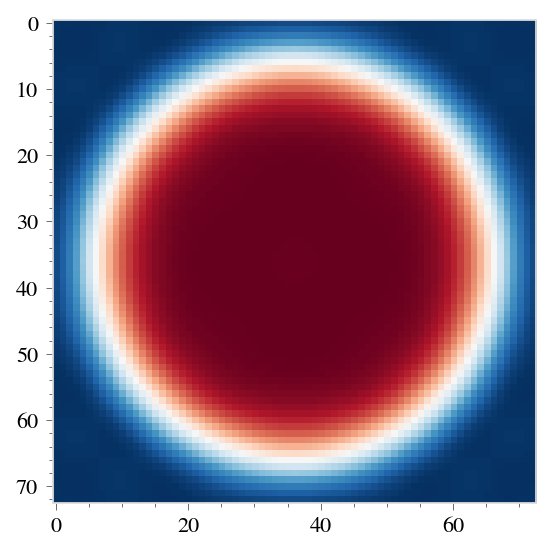

In [208]:
plt.imshow(eff_filter)

In [209]:
conv = sp.ndimage.filters.convolve1d

filt_map_TRJ = 0
for _u, _s, _v in zip(u, s, v):


    filt_map_TRJ += _s * conv(conv(map_TRJ, _u, axis=0), _v, axis=1)

In [210]:
filt_map_TRJ

array([[-1.11612012e-07, -1.11634705e-07, -1.11680875e-07, ...,
        -1.89321978e-08, -1.89213427e-08, -1.89158767e-08],
       [-1.11639984e-07, -1.11662823e-07, -1.11709267e-07, ...,
        -1.89379340e-08, -1.89271408e-08, -1.89217062e-08],
       [-1.11696657e-07, -1.11719772e-07, -1.11766730e-07, ...,
        -1.89493643e-08, -1.89386934e-08, -1.89333207e-08],
       ...,
       [-1.11884316e-07, -1.11908983e-07, -1.11958044e-07, ...,
        -1.97358299e-08, -1.97344592e-08, -1.97337840e-08],
       [-1.11813945e-07, -1.11838604e-07, -1.11887624e-07, ...,
        -1.97293898e-08, -1.97279571e-08, -1.97272513e-08],
       [-1.11778774e-07, -1.11803435e-07, -1.11852447e-07, ...,
        -1.97261681e-08, -1.97247038e-08, -1.97239825e-08]])

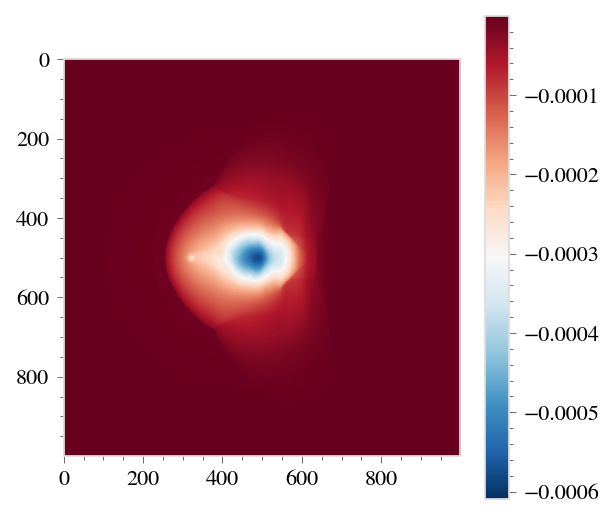

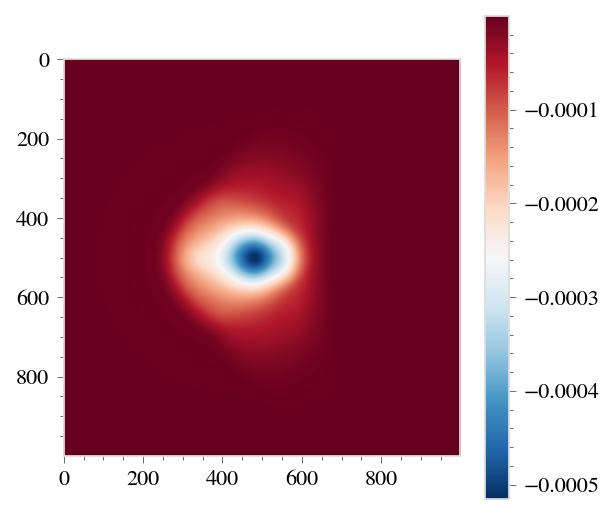

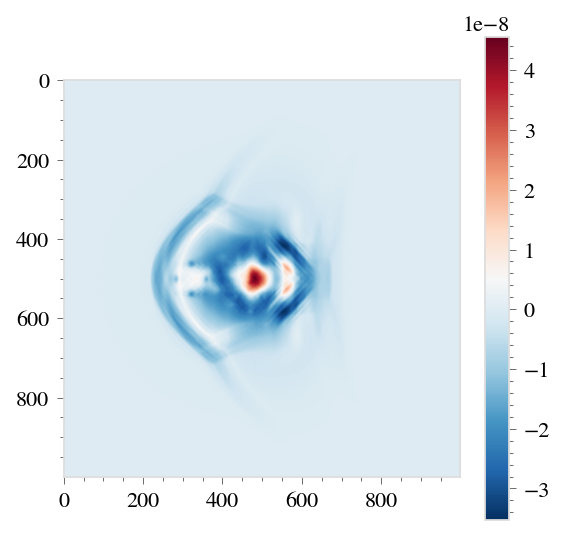

In [211]:


plt.figure()
plt.imshow(map_TRJ)
plt.colorbar()

plt.figure()
plt.imshow(fmap)
plt.colorbar()

plt.figure()
plt.imshow(fmap - filt_map_TRJ)
plt.colorbar()

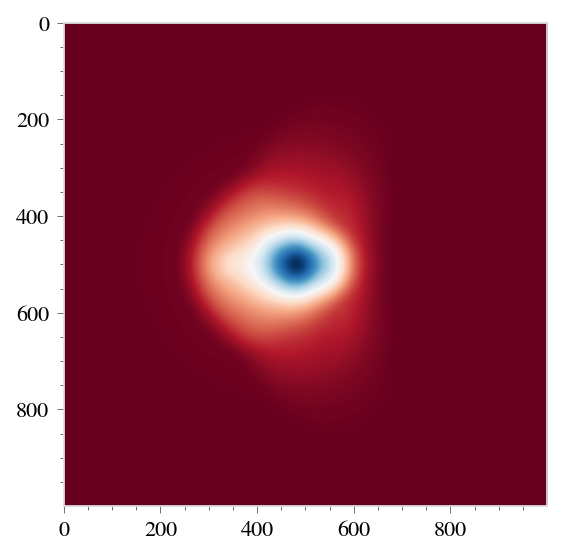

In [186]:
plt.imshow(fmap)

In [183]:
%time fmap = sp.signal.convolve2d(map_TRJ, F, boundary='symm', mode='same')

CPU times: user 15.2 s, sys: 113 ms, total: 15.3 s
Wall time: 15.3 s


<ipython-input-34-0619a25688de>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(60*np.degrees(map_X), 60*np.degrees(map_Y), map_TRJ)


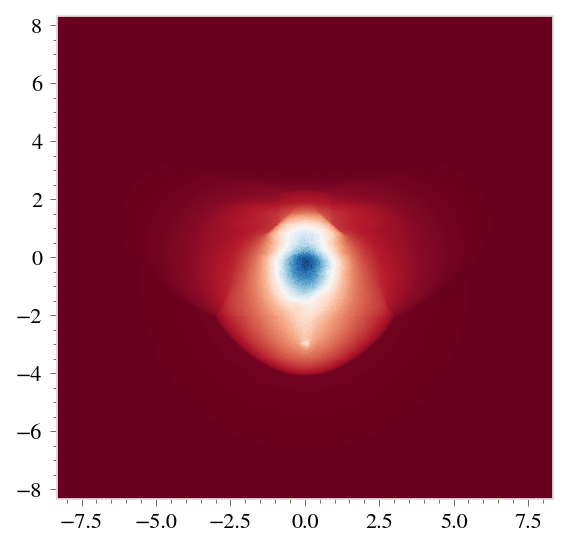

In [34]:
plt.pcolormesh(60*np.degrees(map_X), 60*np.degrees(map_Y), map_TRJ)

In [22]:


map_X

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [997, 997, 997, ..., 997, 997, 997],
       [998, 998, 998, ..., 998, 998, 998],
       [999, 999, 999, ..., 999, 999, 999]])

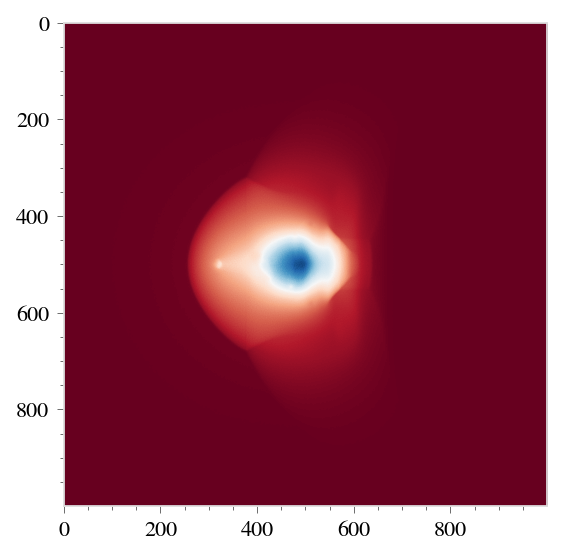

In [12]:
plt.imshow(M)